# Exercise 3.2

### **NB: This notebook was developed in Google Colab**

In [1]:
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import pickle
from collections import OrderedDict
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, ConfusionMatrixDisplay
from tqdm import tqdm
import random

In [2]:
torch.manual_seed(42) # for reproducibility
random.seed(42)

In [3]:
# Define the model
case = 'b'
num_classes = 10
num_epochs = 500

In [4]:
if case == 'a':
    inputs, n_hidden0, n_hidden1, out = 784*3, 64, 16, 10
    ckpt_pth = './drive/MyDrive/a7/best_model_NN.pth'
    model = nn.Sequential(
    nn.Linear(inputs, n_hidden0, bias=True),
    nn.Tanh(),
    nn.Linear(n_hidden0, n_hidden1, bias=True),
    nn.Tanh(),
    nn.Linear(n_hidden1, out, bias=True),
    nn.Softmax()
    ).to('cuda')
elif case == 'b':
    ckpt_pth = './drive/MyDrive/a7/best_model_CNN.pth'
    preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),  # Produces shape [1, H, W] for grayscale
    transforms.Lambda(lambda x: x.expand(3, -1, -1)),  # Convert to 3-channel grayscale
    transforms.Normalize(mean=[0.485, 0.456, 0.406],   # ImageNet mean
                         std=[0.229, 0.224, 0.225])     # ImageNet std
])

    model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
    model.classifier[6] = nn.Linear(4096, num_classes)
    model = model.to('cuda')
else:
    raise ValueError('Case choice is invalid')

model.train()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [5]:
# Load the data
with open('./drive/MyDrive/a7/0_development_data.pkl', 'rb') as f:
    devel_imgs = pickle.load(f)
train_imgs = devel_imgs[0][::2]
val_imgs = devel_imgs[0][1::2]
with open('./drive/MyDrive/a7/0_test_data.pkl', 'rb') as f:
    test_imgs = pickle.load(f)
test_imgs = test_imgs[0]

In [6]:
len(train_imgs), len(val_imgs), len(test_imgs)

(10499, 10498, 21003)

In [7]:
# Extract the labels
labels_train = [int(i[0].split('/')[-2]) for i in train_imgs]
labels_val = [int(i[0].split('/')[-2]) for i in val_imgs]
labels_test = [int(i[0].split('/')[-2]) for i in test_imgs]

Changes below include making all images grayscale, masking bottom right hand corner to remove grey squares, and shuffling data BEFORE making DataLoaders since the images are all in order (all 0s followed by all 1s etc etc)

In [8]:
# Define the data loader and training objects
class CustomDataset(Dataset):
    def __init__(self, image_list, labels, transform=None):
        self.image_list = image_list
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        if case == 'a':
            image = self.image_list[idx].astype(float)
            image /= 255.0 # This should be at dataset level
            image -= np.sum(np.sum(image,0),0) / (image.shape[0]*image.shape[1])
        elif case == 'b':
            img_tmp = self.image_list[idx].copy()  # Prevent modifying original
            img_tmp[-5:, -5:, :] = 0               # Mask bottom-right corner
            img_gray = Image.fromarray(img_tmp).convert('L')  # Convert to grayscale PIL image
            image = preprocess(img_gray)  # Apply transforms (includes expanding to 3 channels to avoid error)

        label = self.labels[idx]
        return image, label

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
if case == 'a':
    optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
else:
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Create CustomDataset instance
train_list = [i[1] for i in train_imgs]
val_list = [i[1] for i in val_imgs]
test_list = [i[1] for i in test_imgs]


# Shuffle training data and labels together
combined_train = list(zip(train_list, labels_train))
random.shuffle(combined_train)
train_list[:], labels_train[:] = zip(*combined_train)

# Shuffle validation data and labels together
combined_val = list(zip(val_list, labels_val))
random.shuffle(combined_val)
val_list[:], labels_val[:] = zip(*combined_val)


dataset_train = CustomDataset(train_list, labels_train, transform=None)
dataset_val = CustomDataset(val_list, labels_val, transform=None)
dataset_test = CustomDataset(test_list, labels_test, transform=None)

# Create DataLoader
batch_size = 32
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)


In [9]:
# Training loop
early_stopping_patience = 10

best_val_loss = 10000.0
for epoch in range(num_epochs):
    running_loss, running_val_loss = 0.0, 0.0
    model.train()
    for inputs_, labels_ in tqdm(dataloader_train):

        if case == 'a': inputs_ = torch.reshape(inputs_, (inputs_.shape[0], -1))
        inputs_, labels_ = inputs_.to(torch.float).to('cuda'), labels_.to('cuda')
        optimizer.zero_grad()
        outputs = model(inputs_)
        loss = criterion(outputs, labels_)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    model.eval()
    with torch.no_grad():
        for inputs_val, labels_val in tqdm(dataloader_val):
            if case == 'a': inputs_val = torch.reshape(inputs_val, (inputs_val.shape[0], -1))
            inputs_val, labels_val = inputs_val.to(torch.float).to('cuda'), labels_val.to('cuda')
            outputs_val = model(inputs_val)
            val_loss = criterion(outputs_val, labels_val)
            running_val_loss += val_loss.item()

    epoch_val_loss = running_val_loss/len(dataloader_val)
    if epoch_val_loss < best_val_loss:
        early_stopping_counter = 0
        best_val_loss = float(epoch_val_loss)
        torch.save(model.state_dict(), ckpt_pth)
    else:
        early_stopping_counter += 1
        if early_stopping_counter==early_stopping_patience:
            print('-------- Early Stopping ------------')
            print(f'Epoch {epoch+1}, Train loss: {running_loss/len(dataloader_train)}, Val loss: {running_val_loss/len(dataloader_val)}')
            break

    print(f'Epoch {epoch+1}, Train loss: {running_loss/len(dataloader_train)}, Val loss: {epoch_val_loss}')

100%|██████████| 329/329 [00:10<00:00, 31.33it/s]


Epoch 1, Train loss: 0.25903439021734437, Val loss: 0.05191350063016443


100%|██████████| 329/329 [00:10<00:00, 30.86it/s]


Epoch 2, Train loss: 0.06389235024408389, Val loss: 0.0338145981848489


100%|██████████| 329/329 [00:10<00:00, 30.57it/s]


Epoch 3, Train loss: 0.05113844748412678, Val loss: 0.027549770720011843


100%|██████████| 329/329 [00:10<00:00, 30.49it/s]


Epoch 4, Train loss: 0.02554714784401687, Val loss: 0.028317346622291573


100%|██████████| 329/329 [00:10<00:00, 31.68it/s]


Epoch 5, Train loss: 0.01991990843095932, Val loss: 0.05215529785582641


100%|██████████| 329/329 [00:10<00:00, 31.24it/s]


Epoch 6, Train loss: 0.016073132064731332, Val loss: 0.018655092543311096


100%|██████████| 329/329 [00:10<00:00, 30.39it/s]


Epoch 7, Train loss: 0.01200361080733594, Val loss: 0.017969849686615514


100%|██████████| 329/329 [00:10<00:00, 31.94it/s]


Epoch 8, Train loss: 0.013104896067596693, Val loss: 0.022298516701883653


100%|██████████| 329/329 [00:10<00:00, 31.90it/s]


Epoch 9, Train loss: 0.006694925479258013, Val loss: 0.018843572904399954


100%|██████████| 329/329 [00:10<00:00, 31.56it/s]


Epoch 10, Train loss: 0.0073573916881486045, Val loss: 0.01591145796056089


100%|██████████| 329/329 [00:10<00:00, 30.59it/s]


Epoch 11, Train loss: 0.006287033521055055, Val loss: 0.023277825701821894


100%|██████████| 329/329 [00:10<00:00, 31.20it/s]


Epoch 12, Train loss: 0.0056640694303695316, Val loss: 0.020170555507299827


100%|██████████| 329/329 [00:10<00:00, 30.60it/s]


Epoch 13, Train loss: 0.004752747258363677, Val loss: 0.018004940821323718


100%|██████████| 329/329 [00:10<00:00, 31.94it/s]


Epoch 14, Train loss: 0.005374830426663474, Val loss: 0.01463067651428276


100%|██████████| 329/329 [00:10<00:00, 31.08it/s]


Epoch 15, Train loss: 0.0022899792804937074, Val loss: 0.014579120571067639


100%|██████████| 329/329 [00:11<00:00, 29.54it/s]


Epoch 16, Train loss: 0.0009855163928043835, Val loss: 0.0169682464064258


100%|██████████| 329/329 [00:10<00:00, 30.59it/s]


Epoch 17, Train loss: 0.0010166473258006222, Val loss: 0.015160977601146871


100%|██████████| 329/329 [00:10<00:00, 30.31it/s]


Epoch 18, Train loss: 0.004005670139441867, Val loss: 0.01952189679198214


100%|██████████| 329/329 [00:10<00:00, 30.46it/s]


Epoch 19, Train loss: 0.004380201380633031, Val loss: 0.015878333678952736


100%|██████████| 329/329 [00:11<00:00, 29.86it/s]


Epoch 20, Train loss: 0.0019920881610354735, Val loss: 0.01654167639462637


100%|██████████| 329/329 [00:11<00:00, 29.56it/s]


Epoch 21, Train loss: 0.002783322844423194, Val loss: 0.016051027930419005


100%|██████████| 329/329 [00:10<00:00, 30.23it/s]


Epoch 22, Train loss: 0.001233823128973683, Val loss: 0.016949615021820123


100%|██████████| 329/329 [00:11<00:00, 29.60it/s]


Epoch 23, Train loss: 0.0007933179406471187, Val loss: 0.01767994087458156


100%|██████████| 329/329 [00:10<00:00, 30.84it/s]


Epoch 24, Train loss: 0.0018414350779468354, Val loss: 0.01751180597301173


100%|██████████| 329/329 [00:10<00:00, 31.43it/s]

-------- Early Stopping ------------
Epoch 25, Train loss: 0.0015724977708399576, Val loss: 0.018121412065471184


In [10]:
# Make predictions on the train data
model.load_state_dict(torch.load(ckpt_pth, weights_only=True))
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [11]:
# Inference function
def get_predictions(input_batch, model):

    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_batch)

    probabilities = torch.nn.functional.softmax(output, dim=1)
    return probabilities

In [12]:
# Run inference
preds_list = []
batch_size = 64
with torch.no_grad():
    for inputs_test, _ in tqdm(dataloader_test):
        if case == 'a': inputs_test = torch.reshape(inputs_test, (inputs_test.shape[0], -1))
        inputs_test = inputs_test.to(torch.float).to('cuda')
        preds_list.append(get_predictions(inputs_test, model).cpu().numpy())
final_preds = np.argmax(np.reshape(np.vstack(preds_list), (-1,10)),1)

100%|██████████| 657/657 [00:20<00:00, 31.64it/s]


Changes made to just display confusion matrix for further performance visualisation

In [13]:
# Generate all interesting metrics
def multiclass_metrics(y_true, y_pred, labels):
    """
    Compute per-class accuracy, sensitivity (recall), specificity, and precision.

    y_true, y_pred : array-like of shape (n_samples,)
    labels         : list of class labels, e.g. [0,1,...,9]
    """
    # Compute the full confusion matrix once
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    # cm[i, j] is count of true class i predicted as class j

    # Prepare containers
    metrics = {
        "class": [],
        "accuracy": [],
        "sensitivity (recall)": [],
        "specificity": [],
        "precision": []
    }

    # Total samples
    total = cm.sum()

    for idx, cls in enumerate(labels):
        TP = cm[idx, idx]
        FN = cm[idx, :].sum() - TP
        FP = cm[:, idx].sum() - TP
        TN = total - TP - FP - FN

        # Per-class metrics
        acc = (TP + TN) / total
        sens = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        spec = TN / (TN + FP) if (TN + FP) > 0 else 0.0
        prec = TP / (TP + FP) if (TP + FP) > 0 else 0.0

        metrics["class"].append(cls)
        metrics["accuracy"].append(acc)
        metrics["sensitivity (recall)"].append(sens)
        metrics["specificity"].append(spec)
        metrics["precision"].append(prec)

    ConfusionMatrixDisplay(cm).plot() # display confusion matrix

    return pd.DataFrame(metrics)


,accuracy,sensitivity (recall),specificity,precision
class,,,,
0,0.926201,0.253630,0.999578,0.984962
1,0.998905,0.996157,0.999250,0.994035
2,0.949150,0.993777,0.944221,0.663047
3,0.997905,0.991728,0.998619,0.988095
4,0.999095,0.999509,0.999051,0.991232
5,0.976860,0.996312,0.974928,0.797890
6,0.999429,0.995650,0.999842,0.998546
7,0.999381,0.997728,0.999575,0.996370
8,0.999000,0.994587,0.999473,0.995076


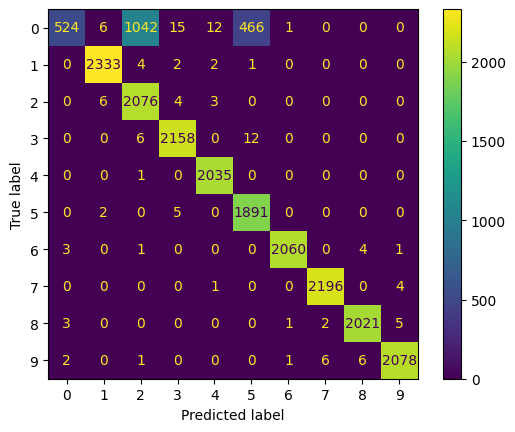

In [14]:
# Report the performance
report_df = multiclass_metrics(labels_test, final_preds, np.arange(10).tolist()).set_index('class')
report_df